In [1]:
# Import required libraries

import numpy as np
import pandas as pd

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import pacf, grangercausalitytests, adfuller

from statsmodels.tsa import tsatools
# from dmba import regressionSummary

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
pd.options.display.max_columns = 20 
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True) # Displays only upto 4 decimals
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress specific FutureWarnings

In [2]:
# Load the Excel files
df_production = pd.read_excel("/Users/SS93988/Downloads/monthly sugar production.xlsx")
df_prices = pd.read_excel("/Users/SS93988/Downloads/Historical sugar prices_indexmundi.xlsx")
df_cpi = pd.read_excel('/Users/SS93988/Downloads/RBI-CPI-MonthlyStats.xlsx', skiprows=1)

In [3]:
df_production

,Month,Year,month Production of sugar \nlakh tonnes,Sugar export by India\nmetric tonnes,Sugar Imports In India\nmeric tonnes
0,October,2023,4.36,462256.0,76719.0
1,November,2023,43.82,669226.0,133.0
2,December,2023,73.02,1586842.0,77946.0
3,January,2023,73.79,1394166.0,73412.0
4,February,2023,63.49,1166624.0,48.0
...,...,...,...,...,...
163,May,2010,4.23,NaN,NaN
164,June,2010,0.69,NaN,NaN
165,July,2010,0.55,NaN,NaN
166,August,2010,1.13,NaN,NaN


In [4]:
df_prices

,Date,Price,Change
0,2018-01-01,39.200000,-
1,2018-02-01,39.100000,-0.002551
2,2018-03-01,38.944444,-0.003978
3,2018-04-01,37.703704,-0.031859
4,2018-05-01,35.358423,-0.062203
...,...,...,...
78,2024-07-01,42.695473,-0.009028
79,2024-08-01,43.266667,0.013378
80,2024-09-01,42.675926,-0.013653
81,2024-10-01,42.884444,0.004886


In [5]:
df_cpi

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Index,Inflation (%),Index.1,Inflation (%).1,Index.2,Inflation (%).2
0,OCT-2024,A) General Index,Provisional,199.5,6.68,193.7,5.62,196.8,6.21
1,OCT-2024,A.1) Food and beverages,Provisional,206.7,9.66,214.0,9.80,209.4,9.69
2,OCT-2024,A.1.1) Cereals and products,Provisional,196.3,7.27,194.0,6.19,195.6,6.94
3,OCT-2024,A.1.2) Meat and fish,Provisional,221.6,3.02,230.5,3.41,224.7,3.17
4,OCT-2024,A.1.3) Egg,Provisional,194,4.75,198.8,5.02,195.9,4.87
...,...,...,...,...,...,...,...,...,...
3970,JAN-2013,A.6.2) Health,Final,104,NaN,104.1,NaN,104.0,NaN
3971,JAN-2013,A.6.3) Transport and communication,Final,103.3,NaN,103.2,NaN,103.2,NaN
3972,JAN-2013,A.6.4) Recreation and amusement,Final,103.4,NaN,102.9,NaN,103.1,NaN
3973,JAN-2013,A.6.5) Education,Final,103.8,NaN,103.5,NaN,103.6,NaN


In [6]:
# Rename columns for clarity and consistency
df_production.columns = [
    'Month', 
    'Year', 
    'Monthly Production (lakh tonnes)', 
    'Sugar Export (metric tonnes)', 
    'Sugar Import (metric tonnes)'
]
df_prices.columns = ['Date', 'Sugar Price', 'Price Change']

df_cpi.columns = ['Month', 'Commodity', 'Provisional/Final', 'Rural Index', 'Rural Inflation %', 'Urban Index', 'Urban Inflation %', 'Combined Index', 'Combined Inflation %']

In [7]:
# Combine 'Month' and 'Year' into a single 'Date' column in production_data
df_production['Date'] = pd.to_datetime(df_production['Month'] + ' ' + df_production['Year'].astype(str))

/var/folders/kc/k75_899174v28v1lc451mpt00000gq/T/ipykernel_53742/2002471536.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_production['Date'] = pd.to_datetime(df_production['Month'] + ' ' + df_production['Year'].astype(str))


In [8]:
# Drop the original 'Month' and 'Year' columns as they are now combined
df_production.drop(columns=['Month', 'Year'], inplace=True)

In [9]:
df_production.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date
0,4.36,462256.0,76719.0,2023-10-01
1,43.82,669226.0,133.0,2023-11-01
2,73.02,1586842.0,77946.0,2023-12-01
3,73.79,1394166.0,73412.0,2023-01-01
4,63.49,1166624.0,48.0,2023-02-01


In [10]:
# Ensure the 'Date' column in prices_data is a datetime object
df_prices['Date'] = pd.to_datetime(df_prices['Date'])

In [11]:
df_prices.head(5)

,Date,Sugar Price,Price Change
0,2018-01-01,39.200000,-
1,2018-02-01,39.100000,-0.002551
2,2018-03-01,38.944444,-0.003978
3,2018-04-01,37.703704,-0.031859
4,2018-05-01,35.358423,-0.062203


In [12]:
# Merge the two datasets on the 'Date' column
data = pd.merge(df_production, df_prices, on='Date', how='outer')

# Sort the merged data by date
data.sort_values('Date', inplace=True)

# Reset the index for a clean dataset
data.reset_index(drop=True, inplace=True)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
data.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change
0,40.94,NaN,NaN,2010-01-01,NaN,NaN
1,37.51,NaN,NaN,2010-02-01,NaN,NaN
2,29.49,NaN,NaN,2010-03-01,NaN,NaN
3,14.19,NaN,NaN,2010-04-01,NaN,NaN
4,4.23,NaN,NaN,2010-05-01,NaN,NaN


In [14]:
# Drop the extra columns, as present in the raw dataset
df_cpi.drop(columns=['Rural Index', 'Rural Inflation %', 'Urban Index', 'Urban Inflation %', 'Combined Index'], inplace=True)
df_cpi

,Month,Commodity,Provisional/Final,Combined Inflation %
0,OCT-2024,A) General Index,Provisional,6.21
1,OCT-2024,A.1) Food and beverages,Provisional,9.69
2,OCT-2024,A.1.1) Cereals and products,Provisional,6.94
3,OCT-2024,A.1.2) Meat and fish,Provisional,3.17
4,OCT-2024,A.1.3) Egg,Provisional,4.87
...,...,...,...,...
3970,JAN-2013,A.6.2) Health,Final,NaN
3971,JAN-2013,A.6.3) Transport and communication,Final,NaN
3972,JAN-2013,A.6.4) Recreation and amusement,Final,NaN
3973,JAN-2013,A.6.5) Education,Final,NaN


In [15]:
# Filtering the data to only look at the Final(non-provisional) Sugar Commodity CPI numbers
df_cpi['Commodity'] = df_cpi['Commodity'].apply(str.lower)
df_cpi = df_cpi[df_cpi["Commodity"].str.contains("sugar")]
df_cpi
df_cpi = df_cpi[df_cpi["Provisional/Final"].str.lower() == 'final']
df_cpi

,Month,Commodity,Provisional/Final,Combined Inflation %
38,SEP-2024,a.1.9) sugar and confectionery,Final,3.46
66,AUG-2024,a.1.9) sugar and confectionery,Final,4.70
94,JUL-2024,a.1.9) sugar and confectionery,Final,5.22
122,JUN-2024,a.1.9) sugar and confectionery,Final,5.83
150,MAY-2024,a.1.9) sugar and confectionery,Final,5.70
...,...,...,...,...
3846,MAY-2013,a.1.9) sugar and confectionery,Final,NaN
3874,APR-2013,a.1.9) sugar and confectionery,Final,NaN
3902,MAR-2013,a.1.9) sugar and confectionery,Final,NaN
3930,FEB-2013,a.1.9) sugar and confectionery,Final,NaN


In [16]:
# Dropping the Commodity and Provisional/Final columns as they are not needed anymore
df_cpi = df_cpi.drop(columns=['Commodity', 'Provisional/Final']).dropna().reset_index(drop=True)
df_cpi

,Month,Combined Inflation %
0,SEP-2024,3.46
1,AUG-2024,4.70
2,JUL-2024,5.22
3,JUN-2024,5.83
4,MAY-2024,5.70
...,...,...
124,MAY-2014,-0.29
125,APR-2014,-1.64
126,MAR-2014,-4.41
127,FEB-2014,-5.61


In [17]:
# Converting the existing month column into the correct (python-friendly) datetime format and renaming the columns
df_cpi['Month'] = pd.to_datetime(df_cpi['Month'], format=r"%b-%Y")
df_cpi.columns = ['Date', 'CPI']
df_cpi

,Date,CPI
0,2024-09-01,3.46
1,2024-08-01,4.70
2,2024-07-01,5.22
3,2024-06-01,5.83
4,2024-05-01,5.70
...,...,...
124,2014-05-01,-0.29
125,2014-04-01,-1.64
126,2014-03-01,-4.41
127,2014-02-01,-5.61


In [18]:
# Merge the cpi data with the merged dataset of production and prices on the 'Date' column
data = pd.merge(data, df_cpi, on='Date', how='outer')

# Sort the merged data by date
data.sort_values('Date', inplace=True)

# Reset the index for a clean dataset
data.reset_index(drop=True, inplace=True)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

data.head(5)

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,40.94,NaN,NaN,2010-01-01,NaN,NaN,NaN
1,37.51,NaN,NaN,2010-02-01,NaN,NaN,NaN
2,29.49,NaN,NaN,2010-03-01,NaN,NaN,NaN
3,14.19,NaN,NaN,2010-04-01,NaN,NaN,NaN
4,4.23,NaN,NaN,2010-05-01,NaN,NaN,NaN


In [19]:
#  Check for Missing Values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Monthly Production (lakh tonnes)    11
Sugar Export (metric tonnes)        59
Sugar Import (metric tonnes)        59
Date                                 0
Sugar Price                         96
Price Change                        96
CPI                                 50
dtype: int64


In [20]:
# Filter rows where all five columns have non-missing values
complete_data = data.dropna(subset=[
    # 'Monthly Production (lakh tonnes)', 
    # 'Sugar Export (metric tonnes)', 
    # 'Sugar Import (metric tonnes)', 
    'Sugar Price',
    # 'CPI'
])

# Display the dates where all five columns have data
dates_with_all_data = complete_data['Date']

print("Dates with all five attributes available:")
print(dates_with_all_data)

Dates with all five attributes available:
96    2018-01-01
97    2018-02-01
98    2018-03-01
99    2018-04-01
100   2018-05-01
         ...    
174   2024-07-01
175   2024-08-01
176   2024-09-01
177   2024-10-01
178   2024-11-01
Name: Date, Length: 83, dtype: datetime64[ns]


In [21]:
complete_data = complete_data.round(2).reset_index(drop=True)

In [22]:
complete_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,67.67,97131.0,321130.0,2018-01-01,39.20,-,2.77
1,60.54,114127.0,0.0,2018-02-01,39.10,-0.002551,-0.17
2,51.64,134766.0,59110.0,2018-03-01,38.94,-0.003978,-1.61
3,28.48,159955.0,0.0,2018-04-01,37.70,-0.031859,-4.05
4,9.18,218721.0,135470.0,2018-05-01,35.36,-0.062203,-8.21
...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,2024-07-01,42.70,-0.009028,5.22
79,NaN,NaN,NaN,2024-08-01,43.27,0.013378,4.70
80,NaN,NaN,NaN,2024-09-01,42.68,-0.013653,3.46
81,NaN,NaN,NaN,2024-10-01,42.88,0.004886,NaN


In [23]:
complete_data.to_csv('final_sugar_price_forecasting_data.csv', index=False)

In [24]:
# Select features, target variable, and dates
X = complete_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]
y = complete_data['Sugar Price']
dates = complete_data['Date']


# Split into training (before 2022) and testing (2022-2023) data
train_size = int(len(complete_data) * 0.9)
train_data = complete_data[:train_size]
test_data = complete_data[train_size:]

In [25]:
train_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
0,67.67,97131.0,321130.0,2018-01-01,39.20,-,2.77
1,60.54,114127.0,0.0,2018-02-01,39.10,-0.002551,-0.17
2,51.64,134766.0,59110.0,2018-03-01,38.94,-0.003978,-1.61
3,28.48,159955.0,0.0,2018-04-01,37.70,-0.031859,-4.05
4,9.18,218721.0,135470.0,2018-05-01,35.36,-0.062203,-8.21
...,...,...,...,...,...,...,...
69,4.36,462256.0,76719.0,2023-10-01,43.85,0.004673,5.50
70,43.82,669226.0,133.0,2023-11-01,44.46,0.013846,6.55
71,73.02,1586842.0,77946.0,2023-12-01,44.33,-0.002959,7.22
72,NaN,NaN,NaN,2024-01-01,44.18,-0.003314,7.43


In [26]:
test_data

,Monthly Production (lakh tonnes),Sugar Export (metric tonnes),Sugar Import (metric tonnes),Date,Sugar Price,Price Change,CPI
74,NaN,NaN,NaN,2024-03-01,42.21,0.002753,7.25
75,NaN,NaN,NaN,2024-04-01,43.08,0.020522,6.02
76,NaN,NaN,NaN,2024-05-01,43.56,0.011237,5.70
77,NaN,NaN,NaN,2024-06-01,43.08,-0.01101,5.83
78,NaN,NaN,NaN,2024-07-01,42.70,-0.009028,5.22
79,NaN,NaN,NaN,2024-08-01,43.27,0.013378,4.70
80,NaN,NaN,NaN,2024-09-01,42.68,-0.013653,3.46
81,NaN,NaN,NaN,2024-10-01,42.88,0.004886,NaN
82,NaN,NaN,NaN,2024-11-01,41.78,-0.025806,NaN


Arima Workflow:
1. Run Auto Arima, get a good model through optmization
2. Further use this good model and run optmization manually using for loops for the variables in the vicinity of pdq & PDQ values, Get a better model
3. Use the better model and further fine tune paramters and get the best SARIMA model
4. Add exogenous variables and get the best SARIMAX model.

In [27]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define the exogenous variables
exog_train = train_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]
exog_test = test_data[['Monthly Production (lakh tonnes)', 'Sugar Export (metric tonnes)', 'Sugar Import (metric tonnes)', 'CPI']]

/var/folders/kc/k75_899174v28v1lc451mpt00000gq/T/ipykernel_53742/4174494630.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SARIMAX Forecasted Sugar Price'] = sarimax_forecast


SARIMAX RMSE: 0.5096798660359398
SARIMAX R-squared: 0.015355369108017713
SARIMAX MAE: 0.42302097935146954
SARIMAX MAPE: 0.9905445611275784
SARIMAX MAD: 0.42302097935146954


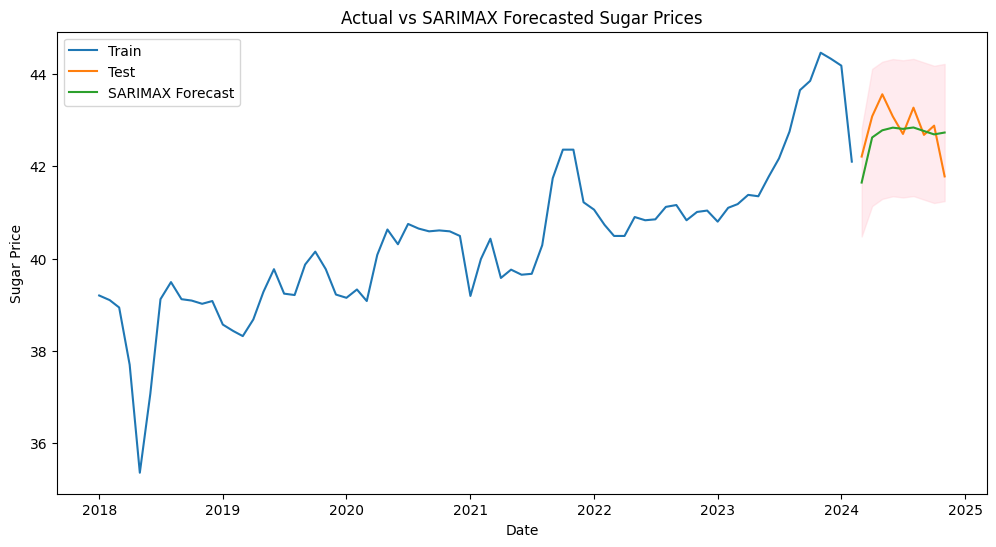

In [28]:
# Define the order and seasonal order
order = (0, 1, 2)
seasonal_order = (2, 0, 2, 12)

# Fit the SARIMAX model on the training data with exogenous variables
sarimax_model = pm.ARIMA(order=order, seasonal_order=seasonal_order, suppress_warnings=True)
sarimax_model.fit(train_data['Sugar Price'], exogenous=exog_train)

# Forecast the sugar prices for the test period using the specified model
sarimax_forecast, sarimax_conf_int = sarimax_model.predict(n_periods=len(test_data), exogenous=False, return_conf_int=True)

# Add the forecasted values to the test data
test_data['SARIMAX Forecasted Sugar Price'] = sarimax_forecast

# Calculate evaluation metrics
sarimax_rmse = np.sqrt(mean_squared_error(test_data['Sugar Price'], test_data['SARIMAX Forecasted Sugar Price']))
sarimax_r2 = r2_score(test_data['Sugar Price'], test_data['SARIMAX Forecasted Sugar Price'])
sarimax_mae = mean_absolute_error(test_data['Sugar Price'], test_data['SARIMAX Forecasted Sugar Price'])
sarimax_mape = np.mean(np.abs((test_data['Sugar Price'] - test_data['SARIMAX Forecasted Sugar Price']) / test_data['Sugar Price'])) * 100
sarimax_mad = np.mean(np.abs(test_data['Sugar Price'] - test_data['SARIMAX Forecasted Sugar Price']))

print(f'SARIMAX RMSE: {sarimax_rmse}')
print(f'SARIMAX R-squared: {sarimax_r2}')
print(f'SARIMAX MAE: {sarimax_mae}')
print(f'SARIMAX MAPE: {sarimax_mape}')
print(f'SARIMAX MAD: {sarimax_mad}')

# Plot the actual vs forecasted sugar prices using the specified model
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Sugar Price'], label='Train')
plt.plot(test_data['Date'], test_data['Sugar Price'], label='Test')
plt.plot(test_data['Date'], test_data['SARIMAX Forecasted Sugar Price'], label='SARIMAX Forecast')
plt.fill_between(test_data['Date'], sarimax_conf_int[:, 0], sarimax_conf_int[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sugar Price')
plt.title('Actual vs SARIMAX Forecasted Sugar Prices')
plt.legend()
plt.show()

In [29]:
import pickle


pickle.dump(sarimax_model, open('./long-term-forecasting-model.pkl', 'wb'))
